In [1]:
import full_nuclide_ap21
import full_nuclide_ap21_r
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pynucastro as pyna
from pynucastro.screening import potekhin_1998

In [2]:
def plot(tmin, tmax, sol, network, outfile='test'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(network.nnuc):
        ax.loglog(sol.t, sol.y[i,:] * network.A[i], label=f"X({network.names[i].capitalize()})")

    ax.set_xlim(tmin, tmax)
    ax.set_ylim(1.e-10, 1.0)
    ax.legend(fontsize="small")

    fig.set_size_inches((10, 8))
    fig.savefig(outfile)

def composition(network):
    
    X0 = np.zeros(network.nnuc)
    X0[network.jco55] = 0.0
    X0[network.jn] = 1.0
    X0[network.jcr48] = 3.4
    X0[network.jfe52] = 0.0
    X0[network.jhe4] = 1.0
    X0[network.jmn51] = 0.0
    X0[network.jni56] = 1.0
    X0[network.jcr56] = 0.0
    X0[network.jfe54] = 0.0
    X0[network.jfe55] = 0.0
    X0[network.jfe56] = 0.0
    X0[network.jmn56] = 0.0
    X0[network.jp] = 1.0
    X0[network.jfe53] = 0.0
    X0[network.jmn52] = 0.0
    X0[network.jco56] = 0.0
    X0[network.jcr49] = 0.0
    
    X0[network.jmn55] = 0.0
    X0[network.jmn54] = 0.0
    X0[network.jmn53] = 0.0
    X0[network.jcr55] = 0.0
    
    
    X0 /= np.sum(X0)
    Y0 = X0/network.A

    return Y0

def plot_ye(tmin, tmax, sol, network, outfile='test'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    y_e = np.zeros_like(sol.t)
    for i in range(network.nnuc):
        y_e += sol.y[i,:] * network.Z[i]

    ax.plot(sol.t, y_e, label=r"$Y_e$")
    ax.set_xscale('log')


    ax.set_xlim(tmin, tmax)
    ax.set_ylim(0.0, 1.0)
    ax.legend(fontsize="small")

    fig.set_size_inches((10, 8))
    fig.savefig(outfile)

    

In [3]:
Y0 = composition(full_nuclide_ap21)
rho = 1.0e8
T = 7.0e9
ye = full_nuclide_ap21.ye(Y0)

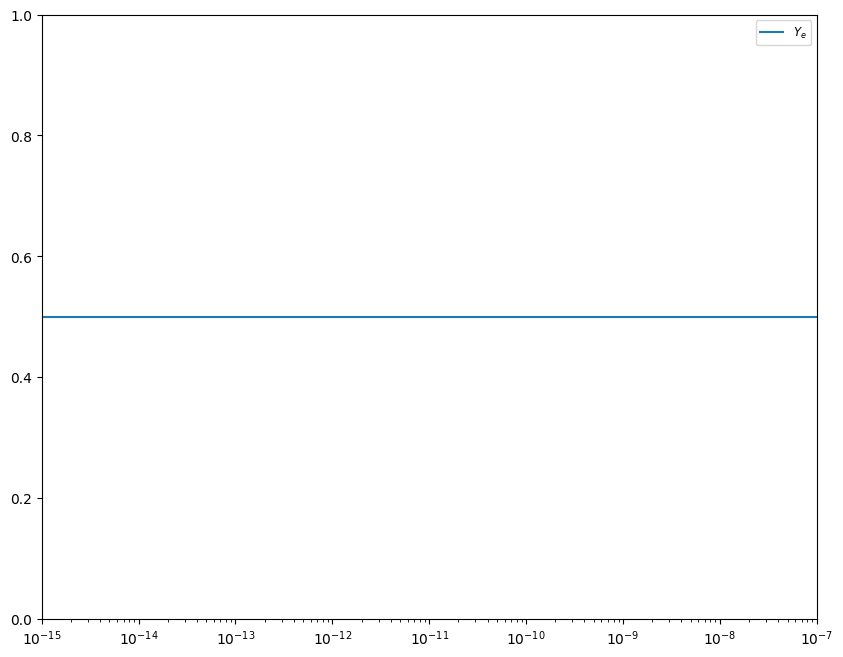

In [4]:
# tmax = 1.0e4
# tmin = 1.0e-1

tmax = 1.0e-7
tmin = 1.0e-15

sol =  solve_ivp(full_nuclide_ap21.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T, potekhin_1998), rtol=1.e-10, atol=1.e-10, jac=full_nuclide_ap21.jacobian)

plot_ye(tmin=tmin, tmax=tmax, sol=sol, network=full_nuclide_ap21, outfile='rho_{:.2e}_T_{:.2e}_ye_{:.2e}.png'.format(rho,T, ye))

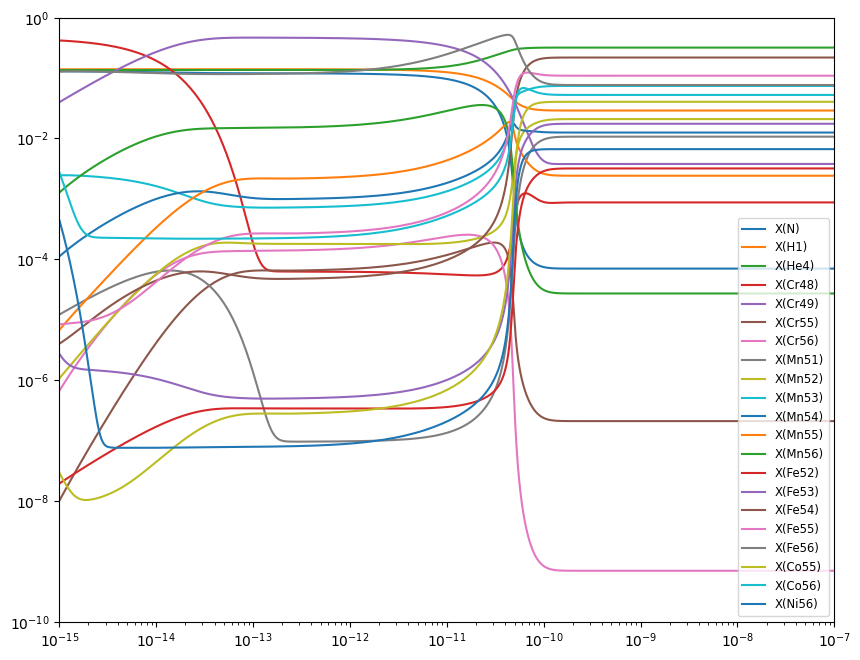

In [5]:
plot(tmin=tmin, tmax=tmax, sol=sol, network=full_nuclide_ap21, outfile='rho_{:.2e}_T_{:.2e}.png'.format(rho,T))

In [6]:
# tmax = 1.0e-2
# tmin = 1.0e-11

# sol_r = solve_ivp(full_nuclide_ap21_r.rhs, [0, tmax], Y0_r, method="BDF",
#                 dense_output=True, args=(rho, T), rtol=1.e-8, atol=1.e-8, jac=full_nuclide_ap21_r.jacobian)

# # sol_r = solve_ivp(full_nuclide_ap21_r.rhs, [0, tmax], Y0_r, method="BDF",
# #                 dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-6)

# plot(tmin=tmin, tmax=tmax, sol=sol_r, network=full_nuclide_ap21_r, outfile='rho_{:.2e}_T_{:.2e}_r.png'.format(rho,T))

# Chhecking the NSE state

In [7]:
# Find NSE composition to compare with integration route:

all_reactions = pyna.ReacLibLibrary()
fwd_reactions = all_reactions.derived_forward()

all_nuclei = ['cr48', 'mn51', 'fe52', 'ni56', 'p', 'n', 'he4', 'co55',
              'fe54','fe55', 'fe56', 'cr56', 'mn56', 'fe53', 'mn52', 'co56', 'cr49']

all_nuclei += ['mn55', 'mn54', 'mn53', 'cr55']

fwd_rates_lib = fwd_reactions.linking_nuclei(nuclist=all_nuclei, with_reverse=False)

derived = []
for r in fwd_rates_lib.get_rates():
    d = pyna.DerivedRate(rate=r, compute_Q=False, use_pf=True)
    derived.append(d)

der_rates_lib = pyna.Library(rates=derived)
full_library = fwd_rates_lib + der_rates_lib

# weak_rates = []
# weak_rates.append(all_reactions.get_rate("n --> p <wc12_reaclib_weak_>"))
# weak_rates.append(all_reactions.get_rate("co55 --> fe55 <wc12_reaclib_weak_>"))
# weak_rates.append(all_reactions.get_rate("cr56 --> mn56 <wc12_reaclib_weak_>"))
# weak_rates.append(all_reactions.get_rate("mn56 --> fe56 <wc12_reaclib_weak_>"))
# weak_rates.append(all_reactions.get_rate("fe52 --> mn52 <wc12_reaclib_weak_>"))
# weak_rates.append(all_reactions.get_rate("co56 --> fe56 <wc12_reaclib_weak_>"))
# weak_rates.append(all_reactions.get_rate("ni56 --> co56 <wc12_reaclib_weak_>"))
# weak_lib = Library(rates=weak_rates)
# full_library += weak_lib

rc = pyna.RateCollection(libraries=full_library)

In [8]:
comp = rc.get_comp_nse(rho, T, ye, init_guess=(-3.5, -14.0), use_coulomb_corr=True)

print("From NSE calculation:")
print(comp)
# for key, value in comp.items():
#     print(key, ":", value)

print(" ")

print("From integration:")
for i in range(full_nuclide_ap21.nnuc):
    print(f"X({full_nuclide_ap21.names[i]}): {sol.y[i,-1]*full_nuclide_ap21.A[i]}")

From NSE calculation:
  X(n) : 7.10415866355107e-05
  X(p) : 0.029371242429682084
  X(he4) : 0.31074702509562424
  X(cr48) : 0.0009317560331415512
  X(cr49) : 0.004007715822205178
  X(cr55) : 2.1055875374439688e-07
  X(cr56) : 6.839739438411525e-10
  X(mn51) : 0.011160053950942356
  X(mn52) : 0.021597556697359875
  X(mn53) : 0.07589626741174446
  X(mn54) : 0.012740059208619262
  X(mn55) : 0.0024352425031564907
  X(mn56) : 2.7134260141759718e-05
  X(fe52) : 0.0032778299467872063
  X(fe53) : 0.017966971882857383
  X(fe54) : 0.22250931778155594
  X(fe55) : 0.11034490777472375
  X(fe56) : 0.07680272155754721
  X(co55) : 0.04086397488065593
  X(co56) : 0.052558221077919284
  X(ni56) : 0.0066907488559253036

 
From integration:
X(n): 7.007963228360582e-05
X(h1): 0.02901898510083073
X(he4): 0.3198631154174859
X(cr48): 0.0008738270902490068
X(cr49): 0.003790309883464941
X(cr55): 2.092327144912067e-07
X(cr56): 6.964369769493432e-10
X(mn51): 0.010718250697032502
X(mn52): 0.020931275024399804
X(m

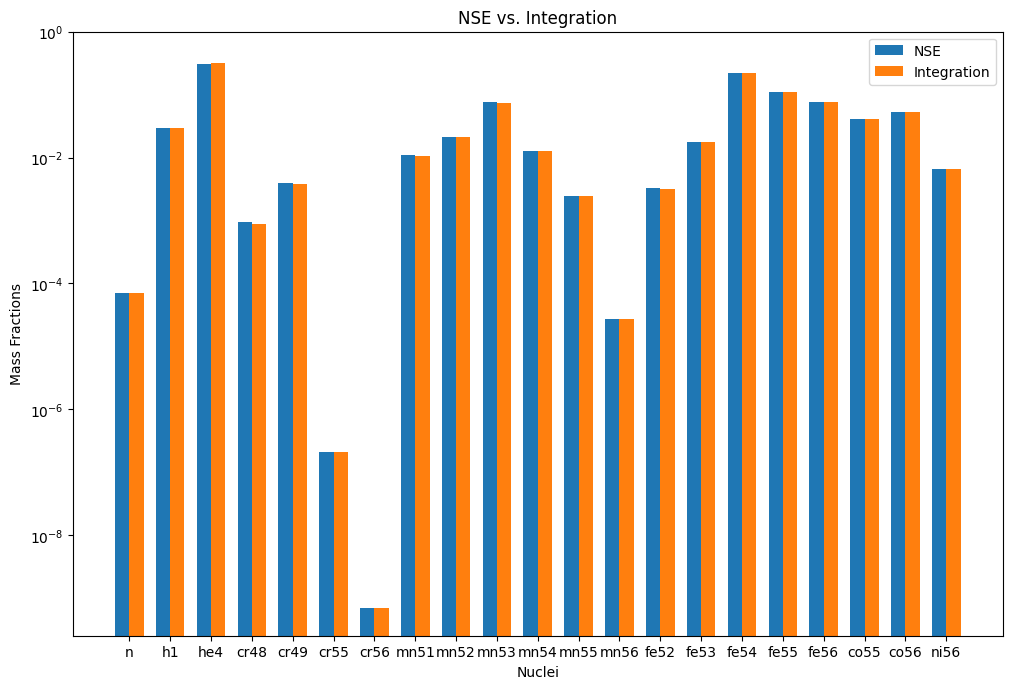

In [9]:
# Bar graph for visual

x = np.arange(len(full_nuclide_ap21.names))
width = 0.35

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.bar(x - width/2.0, list(comp.X.values()), width, label = 'NSE')
ax.bar(x + width/2.0, sol.y[:,-1]*full_nuclide_ap21.A, width, label = 'Integration')
ax.set_xlabel("Nuclei")
ax.set_xticks(x, full_nuclide_ap21.names)
ax.set_ylabel("Mass Fractions")
ax.set_yscale("log")
ax.set_title("NSE vs. Integration")
ax.set_ylim(ymax = 1)
ax.legend()